# Set up

The following package will download the TSV files from IMDB website and store the data into a SQLite database (requires 10GB of disk space)


In [ ]:
!pip install imdb-sqlite

In [ ]:
%%time
!imdb-sqlite

In [ ]:
# Need this package for hadling country ISO codes
!pip install pycountry

In [5]:
# Imports
from matplotlib import cm  # Color maps
from sklearn.feature_extraction.text import CountVectorizer  # Convert a collection of text documents to a matrix of token counts
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


In [18]:
# Some tweaks

warnings.filterwarnings('ignore')  # Don't show warnings
sns.set_theme(style='whitegrid')

# Database structure analysis

In [7]:
# Connect to databse
conn = sqlite3.connect('imdb.db')

In [ ]:
# Retrieve tables' names
tables = pd.read_sql_query('SELECT name AS "Table_name" FROM sqlite_master WHERE type="table"', conn)
tables.head()

In [ ]:
# Retrieve each table's schema

tables_names = tables['Table_name'].values.tolist()

for table_name in tables_names:
    schema = pd.read_sql_query(f'PRAGMA TABLE_INFO({table_name})', conn)
    print(f'Schema for table {table_name}:')
    display(schema)
    print(f'{50 * "_"}\n\n')

# 1. The most common content categories in IMDB

In [ ]:
# Retrieve the data
query = 'SELECT type, COUNT(*) AS abs_frequency FROM titles GROUP BY type ORDER BY abs_frequency DESC'
dataframe = pd.read_sql_query(query, conn)
display(dataframe)

In [ ]:
# Remove tvEpisode type
dataframe = dataframe.drop(labels=0, axis=0)

In [ ]:
# Add the relative_frequency
sum_abs_freq = dataframe['abs_frequency'].sum()
dataframe['rel_frequency'] = (dataframe['abs_frequency'] / sum_abs_freq) * 100
display(dataframe)

Now let's create a graph with 5 categories:

4 categories with the the biggest amount of titles.

1 category with the others


In [ ]:
# Others category
others = {}
others['type'] = 'others'
others['abs_frequency'] = dataframe.iloc[4:]['abs_frequency'].sum()
others['rel_frequency'] = dataframe.iloc[4:]['rel_frequency'].sum()
others

In [ ]:
# The common title categories dataframe
dataframe = dataframe.head(4)
dataframe = dataframe.append(others, ignore_index=True)  # Append others category
dataframe = dataframe.sort_values(by='rel_frequency', ascending=False)
dataframe

In [ ]:
# Labels
labels = []

for i in dataframe.index:
    cont_type = dataframe.loc[i]["type"]
    cont_type = re.sub(r"(\w)([A-Z])", r"\1 \2", cont_type) # Add space before capital letters
    cont_type = cont_type[0].upper() + cont_type[1:] # Uppercase the first letter without changing the rest

    rel_freq = round(dataframe.loc[i]["rel_frequency"], 2)

    labels.append(f'{cont_type} {rel_freq}%')

labels

In [ ]:
# Plot

# Set color map
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
cs = cm.tab10(range(100))

plt.pie(dataframe['rel_frequency'], colors = cs, labeldistance = 1, radius = 3, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', fontsize = 12)
plt.title(label = 'Content Categories', loc = 'center', fontdict = {'fontsize':20,'fontweight':20})
plt.show()

# 2. Percentage of movies per genre

In [ ]:
# Retrieve movie genres and sort them
query = 'SELECT genres FROM titles WHERE type="movie"'
dataframe = pd.read_sql_query(query, conn)
display(dataframe)

In [ ]:
# Lowercase genres
dataframe['genres'] = dataframe['genres'].str.lower()

In [9]:
# Function for removing missing values

def rm_miss_values(df: pd.DataFrame, column: str, miss_indicator: str = '\\n') -> pd.DataFrame:
    df[column].replace(miss_indicator, np.nan, inplace=True)
    cleared_df = df.dropna(subset=[column])
    return cleared_df

In [ ]:
# Remove missing values
genres_df = rm_miss_values(dataframe, 'genres')
display(genres_df)

#### How CountVectorizer works:

![How CountVectorizer works](https://mlwhiz.com/images/countvectorizer.png)

In [8]:
# Function that creates a dataframe with unique genres and the respectively absolute frequency

def df_uniq_genres_abs_freq(df: pd.DataFrame, column: str) -> pd.DataFrame:
    # Match words with lenght > 1 and with - or not
    pattern = '(?u)\\b\\w[\\w-]+\\b'

    # Deals with multi-categorical data
    vect = CountVectorizer(token_pattern=pattern).fit(df[column])

    # Create Document-term matrix.
    bag_genres = vect.transform(df[column])

    # Create array of unique genres
    unique_genres = vect.get_feature_names()

    # Sum sparse matrix columns
    genres_abs_freq = bag_genres.toarray().sum(axis = 0)

    # Return DataFrame with genres and absolute frequencies
    return pd.DataFrame(zip(unique_genres, genres_abs_freq), columns=['genre', 'abs_freq'])

In [ ]:
# Create final dataframe
genres_df = df_uniq_genres_abs_freq(genres_df, column='genres')
genres_df

In [ ]:
# Sum of absolute frequencies
freq_total_sum = genres_df['abs_freq'].sum()
freq_total_sum

In [ ]:
# Sort by absolute frequency
genres_df = genres_df.sort_values(by='abs_freq', ascending=False)
genres_df

In [ ]:
# Add relative frequencies to dataframe
genres_df['rel_freq'] = [(abs_freq / freq_total_sum) * 100 for abs_freq in genres_df['abs_freq']]
genres_df

In [ ]:
# Plot

plt.figure(figsize=(16, 8))
sns.barplot(x=genres_df['rel_freq'].tolist(), y=genres_df['genre'].tolist(),
            orient='h', palette='terrain')
plt.ylabel('Gender')
plt.xlabel('Percentual of movies (%)')
plt.title('Percentage of movie genres')
plt.show()


# 3. Movie ratings median per genre

In [4]:
query = 'SELECT rating, genres AS genre FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE type = "movie"'

In [5]:
genre_df = pd.read_sql_query(query, conn)
display(genre_df)

,rating,genre
0,4.4,\N
1,6.1,"Action,Adventure,Biography"
2,5.0,Drama
3,4.5,Drama
4,3.9,Drama
...,...,...
273316,3.5,"Action,Adventure,Thriller"
273317,5.8,Thriller
273318,6.4,"Drama,History"
273319,3.8,"Adventure,History,War"


In [6]:
genre_df['genre'] = genre_df['genre'].str.lower()
display(genre_df)

,rating,genre
0,4.4,\n
1,6.1,"action,adventure,biography"
2,5.0,drama
3,4.5,drama
4,3.9,drama
...,...,...
273316,3.5,"action,adventure,thriller"
273317,5.8,thriller
273318,6.4,"drama,history"
273319,3.8,"adventure,history,war"


In [10]:
# Remove missing values
genre_df = rm_miss_values(genre_df, column='genre')
display(genre_df)

,rating,genre
1,6.1,"action,adventure,biography"
2,5.0,drama
3,4.5,drama
4,3.9,drama
5,4.7,drama
...,...,...
273316,3.5,"action,adventure,thriller"
273317,5.8,thriller
273318,6.4,"drama,history"
273319,3.8,"adventure,history,war"


In [11]:
genre_df = df_uniq_genres_abs_freq(genre_df, column='genre')
genre_df

,genre,abs_freq
0,action,28315
1,adult,4224
2,adventure,17152
3,animation,4799
4,biography,8232
5,comedy,67741
6,crime,23317
7,documentary,40379
8,drama,121092
9,family,10608


In [12]:
# Compute the rating median for each gender
def genre_rating_median(genres: list, conn: sqlite3.Connection) -> dict:
    genre_ratings = {}

    for genre in genres:
        query = f'SELECT rating FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE "%{genre}%" AND type = "movie"'
        result = pd.read_sql_query(query, conn)
        genre_ratings[genre] = np.median(result['rating'])

    return genre_ratings

In [13]:
genre_ratings = genre_rating_median(genre_df['genre'], conn)
genre_ratings

{'action': 5.8,
 'adult': 5.9,
 'adventure': 6.0,
 'animation': 6.4,
 'biography': 7.0,
 'comedy': 6.0,
 'crime': 6.1,
 'documentary': 7.3,
 'drama': 6.3,
 'family': 6.3,
 'fantasy': 6.1,
 'film-noir': 6.6,
 'game-show': 6.800000000000001,
 'history': 6.9,
 'horror': 5.0,
 'music': 6.6,
 'musical': 6.2,
 'mystery': 6.0,
 'news': 7.3,
 'reality-tv': 6.1,
 'romance': 6.2,
 'sci-fi': 5.4,
 'short': 7.2,
 'sport': 6.7,
 'talk-show': 6.9,
 'thriller': 5.6,
 'war': 6.6,
 'western': 6.0}

In [14]:
# Game Show, Talk Show, Reality TV and News aren't movie genres, so lets remove them

for genre in ['game-show', 'talk-show', 'news', 'reality-tv']:
    genre_ratings.pop(genre)
    genre_df = genre_df[genre_df.genre != genre]

display(genre_df)
genre_ratings

,genre,abs_freq
0,action,28315
1,adult,4224
2,adventure,17152
3,animation,4799
4,biography,8232
5,comedy,67741
6,crime,23317
7,documentary,40379
8,drama,121092
9,family,10608


{'action': 5.8,
 'adult': 5.9,
 'adventure': 6.0,
 'animation': 6.4,
 'biography': 7.0,
 'comedy': 6.0,
 'crime': 6.1,
 'documentary': 7.3,
 'drama': 6.3,
 'family': 6.3,
 'fantasy': 6.1,
 'film-noir': 6.6,
 'history': 6.9,
 'horror': 5.0,
 'music': 6.6,
 'musical': 6.2,
 'mystery': 6.0,
 'romance': 6.2,
 'sci-fi': 5.4,
 'short': 7.2,
 'sport': 6.7,
 'thriller': 5.6,
 'war': 6.6,
 'western': 6.0}

In [15]:
# Create column rating and sort them

genre_df['rating'] = genre_ratings.values()
genre_df = genre_df.sort_values(by='rating', ascending=False)
genre_df

,genre,abs_freq,rating
7,documentary,40379,7.3
22,short,23,7.2
4,biography,8232,7.0
13,history,7513,6.9
23,sport,3224,6.7
26,war,5874,6.6
11,film-noir,762,6.6
15,music,6368,6.6
3,animation,4799,6.4
8,drama,121092,6.3


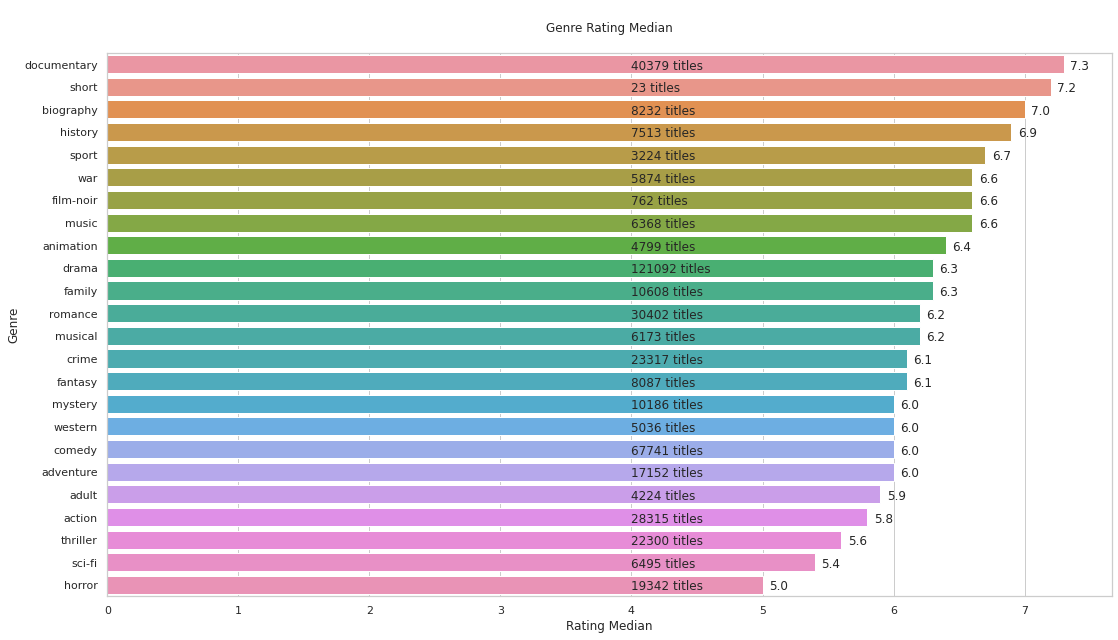

In [34]:
# Plot

plt.figure(figsize=(18, 10))
sns.barplot(x=genre_df['rating'], y=genre_df['genre'], orient='h')

# Plot Text
for i in range(len(genre_df.index)):
    plt.text(x=4, y=i + .22,
             s=f'{genre_df["abs_freq"][genre_df.index[i]]} titles')

    rating = genre_df['rating'][genre_df.index[i]]
    plt.text(x=rating + .05, y=i + .22, s=rating)

plt.xlabel('Rating Median')
plt.ylabel('Genre')
plt.title('\nGenre Rating Median\n')
plt.show()

# 4. Median of movie ratings by premiered year

In [9]:
query = 'SELECT rating, premiered FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE type = "movie" ORDER BY premiered'

In [10]:
df = pd.read_sql_query(query, conn)
display(df)

,rating,premiered
0,5.6,NaN
1,7.5,NaN
2,7.4,NaN
3,4.8,NaN
4,5.7,NaN
...,...,...
273316,5.4,2022.0
273317,8.0,2022.0
273318,8.0,2022.0
273319,1.7,2022.0


In [12]:
# Clear empty values

df.dropna(axis=0, inplace=True)
df

,rating,premiered
27,6.2,1896.0
28,4.5,1897.0
29,3.9,1899.0
30,3.7,1899.0
31,6.0,1900.0
...,...,...
273316,5.4,2022.0
273317,8.0,2022.0
273318,8.0,2022.0
273319,1.7,2022.0


In [13]:
# Computes the median

ratings = {}
for i in set(df['premiered']):
    ratings_df = df[df['premiered'] == i]['rating']
    ratings[i] = np.median(ratings_df)

ratings

{1896.0: 6.2,
 1897.0: 4.5,
 1899.0: 3.8,
 1900.0: 5.85,
 1901.0: 4.6,
 1902.0: 3.5,
 1903.0: 5.6,
 1904.0: 5.4,
 1905.0: 4.4,
 1906.0: 3.7,
 1907.0: 4.5,
 1908.0: 5.3,
 1909.0: 4.8,
 1910.0: 4.8,
 1911.0: 4.6,
 1912.0: 5.6,
 1913.0: 5.7,
 1914.0: 6.0,
 1915.0: 6.2,
 1916.0: 6.2,
 1917.0: 6.2,
 1918.0: 6.0,
 1919.0: 6.1,
 1920.0: 5.7,
 1921.0: 6.2,
 1922.0: 6.2,
 1923.0: 6.3,
 1924.0: 6.4,
 1925.0: 6.3,
 1926.0: 6.4,
 1927.0: 6.5,
 1928.0: 6.6,
 1929.0: 6.4,
 1930.0: 6.05,
 1931.0: 6.0,
 1932.0: 6.2,
 1933.0: 6.3,
 1934.0: 6.2,
 1935.0: 6.2,
 1936.0: 6.2,
 1937.0: 6.2,
 1938.0: 6.2,
 1939.0: 6.3,
 1940.0: 6.3,
 1941.0: 6.3,
 1942.0: 6.2,
 1943.0: 6.3,
 1944.0: 6.2,
 1945.0: 6.2,
 1946.0: 6.4,
 1947.0: 6.4,
 1948.0: 6.4,
 1949.0: 6.4,
 1950.0: 6.3,
 1951.0: 6.3,
 1952.0: 6.3,
 1953.0: 6.2,
 1954.0: 6.2,
 1955.0: 6.3,
 1956.0: 6.2,
 1957.0: 6.3,
 1958.0: 6.3,
 1959.0: 6.3,
 1960.0: 6.4,
 1961.0: 6.3,
 1962.0: 6.3,
 1963.0: 6.3,
 1964.0: 6.3,
 1965.0: 6.2,
 1966.0: 6.2,
 1967.0: 6.2,
 196

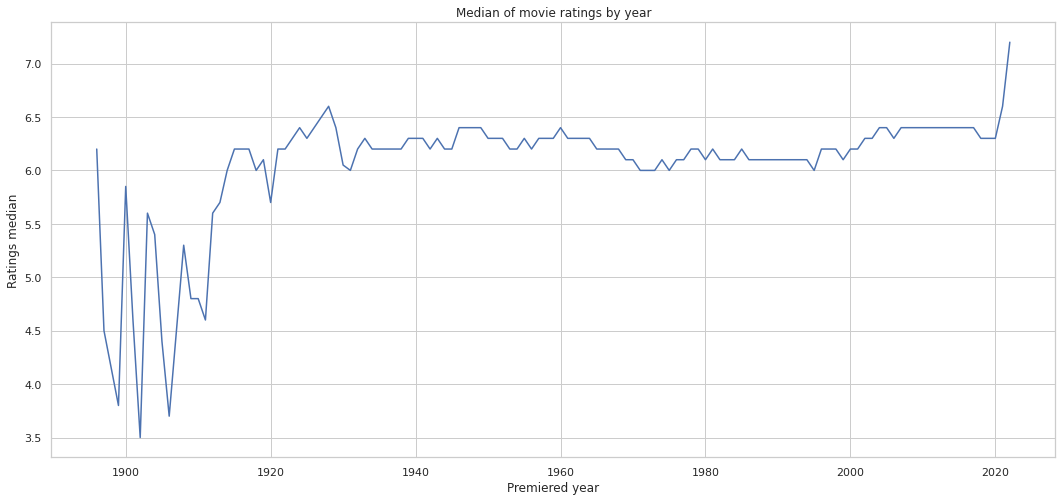

In [19]:
# Plot

plt.figure(figsize=(18, 8))
sns.lineplot(x=ratings.keys(), y=ratings.values())
plt.title('Median of movie ratings by year')
plt.xlabel('Premiered year')
plt.ylabel('Ratings median')
plt.show()